# How to analyse animal behavior data on a 24 hour cycle

# Introduction

Data that examines how often animals do something at certain times of the day is an example of circular data. Circular data has special properties because the zero point is arbitrary. For example, we often treat data from midnight to 1 AM as hour 0 of a day.  Data from 11 PM to 11:59:59 PM are then hour 23 of the day. This designation of midnight as hour 0 is arbitrary as we could just as well treat noon, sunrise, sunset, or 9:23 AM as the start of hour 0. In addition, 11:59 and 12:01 are only 2 minutes apart but using hour of the day they are completely different being at hours 0 and 23, respectively. This can be problematic when using regression analyses where time of day is treated as a continuous variable. 

Data with no true zero point has unique properties that require special statistical consideration. This notebook will walk you through some things to consider when analysing these types of data. While we focus on time of day in this notebook, day of year and location on the planet have similar properties but only if your sampling includes the "full circle".

For these examples, we will use Stata as our analysis and data processing software and the first step is to load Stata.

In [1]:
import ipystata
from ipystata.config import config_stata
config_stata("C:\Program Files\Stata17\StataMP-64.exe") 

In [2]:
%%stata 
display "Stata " c(version) " is running"


Stata 17 is running



## Ovenbird singing behavior at a single location

OK, lets start with a very simple question. Does the number of songs per minute of Ovenbirds vary across a 24 cycle? For this, we selected a single location from WildTrax where Ovenbirds were know to occur (H-P10-31-33). We tagged every song of the Ovenbird we heard per minute in 72 unique audio recordings. ARUs collected a 1-minute recording every 20 minutes across a 24-hour period.  The date was May 29, 2021. The WildTrax project that holds the recordings is [here](https://www.wildtrax.ca/home/aru-tasks.html?sensorId=ARU&projectId=1333). 

Now lets import the downloaded contents of the ZIP file that comes from WildTrax and get it setup in Stata so we can do some analysis.  The WildTrax ZIP file for a single project as of Nov. 30, 2022 should contain 7 csv files. If you downloaded multiple projects you will have more files than this and will need to merge the files from seperate projects to do these analyses.  To merge data from multiple projects, you can run the ado commmand wst_append from [wildSTATAtrax](https://github.com/erinbayne/wildSTATAtrax).  The command wst_append unzips, organizes each file type into folders, and appends multiple projects together in Stata format.  However, for this example we will simply import the csv file directly from GitHub. The first row of data is shown.

### Data setup

In [3]:
%%stata
import delimited "J:\My Drive\HowTo\TimeOfDay\BU_TimeOFDay_basic_summary.csv", bindquote(strict) maxquotedrows(100) clear
list in 1, noobs display 

(encoding automatically selected: UTF-8)
(18 vars, 1,316 obs)

  +------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
  | organi~n | project~e |    location |      recording_date | longitude | latitude |   method |      status |   observer | speci~de | speci~me | speci~ss | indivi~r | tag_st~s |
  |       BU | TimeOFDay | H-P10-31-33 | 2021-05-29 00:00:00 | -115.5433 | 57.90169 | 60s None | Transcribed | Erin Bayne |     NONE |     NONE |          |        . |        . |
  |----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------|
  |                 vocali~n                 |                 abunda~e                  |                 speci~ts                  |                 is_ver~d                  |
  |                                       

The first thing we have to do is configure the data to properly track time of day. Each statistical package does this somewhat differently but in virtually all software time of day is stored interally as a proportion of the day with midnight being 0 and 11:59:59 PM being 0.99999th of a day. What you see in a data table for time of day often should be viewed as a label rather than the actual numbers that the computer uses for computation. If time is stored as text you have to convert it first. Below is a screen shot of Excel showing how it "views dates" versus the numbers it actually uses when computing time of day statistics.

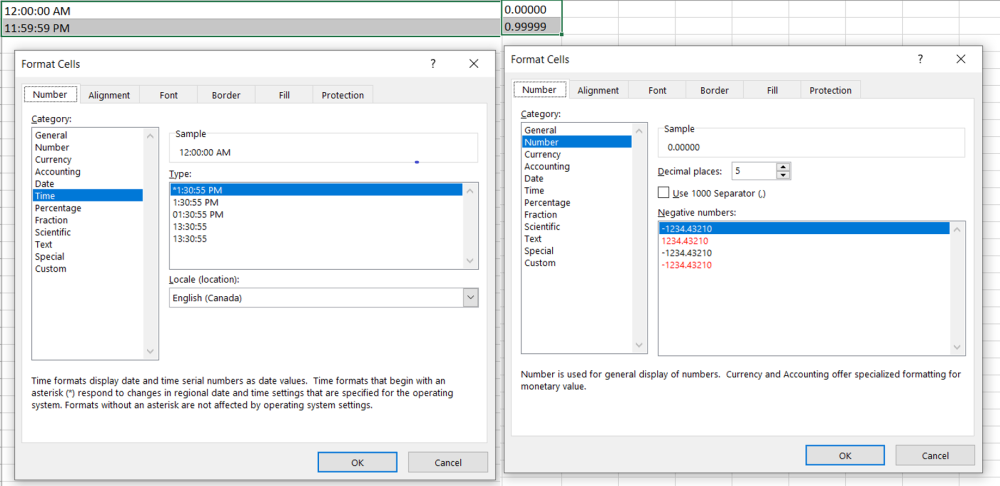

The code below configures time of day data into Stata format.  This code can be run as an ado command wst_formatdatetime from [wildSTATAtrax](https://github.com/erinbayne/wildSTATAtrax) where you provide the date/time field as an argument.  However, in this notebook we use the code using a fixed variable name.

In [4]:
%%stata
gen double datetime = clock(recording_date, "YMDhms")
format datetime %tc
gen syear = yofd(dofc(datetime))
gen sdoy = doy(dofc(datetime))
gen shod = hh(datetime)
gen propday = hh(datetime) + mm(datetime)/60

Now in WildTrax you need to know what your units of time are and "what was counted".  In this example, we tagged each song by each individual Ovenbird per minute.  In the basic_summary___file.csv, WildTrax stores each tag (i.e. each song).  Thus, for this analysis we first need to calculate the total number of songs per minute for all individuals and describe the overall patterns. 

(1,129 missing values generated)

(1,129 real changes made)

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
     songcnt |         72    4.541667      4.5407          0         16

      (sum) |
     detect |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |         23       31.94       31.94
          1 |          4        5.56       37.50
          2 |          4        5.56       43.06
          3 |          5        6.94       50.00
          4 |          2        2.78       52.78
          5 |          7        9.72       62.50
          6 |          5        6.94       69.44
          7 |          5        6.94       76.39
          8 |          1        1.39       77.78
          9 |          2        2.78       80.56
         10 |          5        6.94       87.50
         11 |          4        5.56       93.06
         13 |         

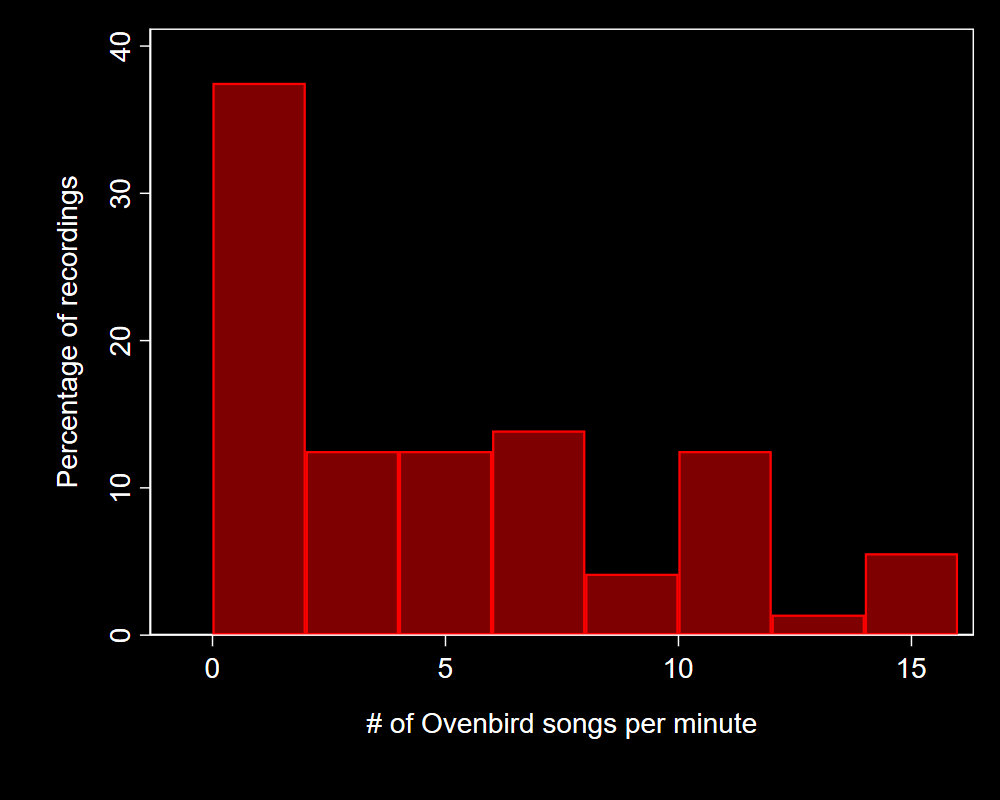

In [5]:
%%stata
gen detect = 0 if species_code=="NONE"
replace detect = 1 if species_code=="OVEN"
frame put *, into(baseTIMEOFDAY)
collapse (sum) songcnt = detect (first) shod propday location, by(datetime)
frame put *, into(byminTIMEOFDAY)
summarize songcnt if location=="H-P10-31-33"
tabulate songcnt  if location=="H-P10-31-33"
histogram songcnt if location=="H-P10-31-33", percent fcolor(red%50) lcolor(red) ytitle(Percentage of recordings) ytitle(, margin(medium)) xtitle(# of Ovenbird songs per minute) xtitle(, margin(medium))

The raw data are clearly not normal and may or may not fit a Poisson distribution.  That is not particularly important as this point but will become more important later.  More importantly there are 1-minute survey periods where the song count is zero. 

### Data Analysis - Chi-square - Goodness of fit

A chi-square test goodness of fit test is often used to determine whether a variable is likely to come from a specified distribution or not. If our null hypothesis is there is no temporal pattern over the day in Ovenbird singing behavior then we would assume a uniform distribution (equal numbers) at every time of the day.  A general rule for a goodness of fit test is that the count in each category (i.e. time period) has a count more than zero and ideally at least 5.  This can be quite limiting as an analysis tool because it is possible than Ovenbirds never call at a particular time of day.  So lets check to see what the observed count is in each time period for Ovenbirds.  

In [6]:
%%stata
generate timetext = string(datetime, "%tcHH:MM")
tabstat songcnt if location=="H-P10-31-33", by(timetext) nototal


Summary for variables: songcnt
Group variable: timetext 

timetext |      Mean
---------+----------
   00:00 |         0
   00:20 |         0
   00:40 |         0
   01:00 |         0
   01:20 |         0
   01:40 |         0
   02:00 |         0
   02:20 |         0
   02:40 |         0
   03:00 |         0
   03:20 |         0
   03:40 |         0
   04:00 |         2
   04:20 |         7
   04:40 |        16
   05:00 |        10
   05:20 |        15
   05:40 |        14
   06:00 |        11
   06:20 |        10
   06:40 |         7
   07:00 |        11
   07:20 |         6
   07:40 |        10
   08:00 |         6
   08:20 |        13
   08:40 |        11
   09:00 |        11
   09:20 |        14
   09:40 |         5
   10:00 |        10
   10:20 |         7
   10:40 |         1
   11:00 |         5
   11:20 |         7
   11:40 |        10
   12:00 |         9
   12:20 |         2
   12:40 |         9
   13:00 |         5
   13:20 |         5
   13:40 |         4
   14:00 |       

Now there are many 1-minute survey periods where the observed song count is zero.  As such a chi-square test is not going to work particularly well.  So lets calculate the total number of songs from our samples based on the hour of the day when Ovenbird songs were counted.  In other words, sum the total song count for Ovenbirds from the three 1-minute survey periods within each hour. 

In [7]:
%%stata
collapse (sum) songcnt , by(shod location)
frame put *, into(hourTIMEOFDAY)
tabstat songcnt if location=="H-P10-31-33", by(shod) stat(sum) 


Summary for variables: songcnt
Group variable: shod ((first) shod)

    shod |       Sum
---------+----------
       0 |         0
       1 |         0
       2 |         0
       3 |         0
       4 |        25
       5 |        39
       6 |        28
       7 |        27
       8 |        30
       9 |        30
      10 |        18
      11 |        22
      12 |        20
      13 |        14
      14 |         6
      15 |         6
      16 |        10
      17 |         5
      18 |         1
      19 |         3
      20 |        17
      21 |        13
      22 |        12
      23 |         1
---------+----------
   Total |       327
--------------------



There still are quite a few hours of the day when the song count for Ovenbirds is zero.  But we will try a chi-square goodness of fit test regardless based on the hypothesis that singing occurs uniformly across the 24 hour period. To do this we take the observed total number of songs and divided by 24 to get the expected count if Ovenbirds sang uniformly across the day. This is our expected value.   

In [8]:
%%stata
gen expected = 327/24
chitest songcnt expected if location=="H-P10-31-33"


observed frequencies from songcnt; expected frequencies from expected

         Pearson chi2(23) = 236.1560   Pr =  0.000
likelihood-ratio chi2(23) = 279.4150   Pr =  0.000

  +-------------------------------------------+
  | observed   expected   obs - exp   Pearson |
  |-------------------------------------------|
  |        0     13.625     -13.625    -3.691 |
  |        0     13.625     -13.625    -3.691 |
  |        0     13.625     -13.625    -3.691 |
  |        0     13.625     -13.625    -3.691 |
  |       25     13.625      11.375     3.082 |
  |-------------------------------------------|
  |       39     13.625      25.375     6.874 |
  |       28     13.625      14.375     3.894 |
  |       27     13.625      13.375     3.623 |
  |       30     13.625      16.375     4.436 |
  |       30     13.625      16.375     4.436 |
  |-------------------------------------------|
  |       18     13.625       4.375     1.185 |
  |       22     13.625       8.375     2.269 |
  |      

The result is fairly clear, Ovenbirds do not seem to sing uniformly across the 24-hour cycle as the *P*-value using a Pearson chi-square is < 0.001.  However, the chi-square is quite limited because it does not provide any descriptive statistics to summarize when Ovenbirds sing or what factors influence the number of songs observed.  Below are some options for doing so.

### Data Analysis - Circular Statistics

To understand the directionality of time of day data, circular statistics can be particularly useful. Circular statistics most often are analyzed in degrees (like a compass).  Thus, before analysis of time of day data it is typical to convert the proportion of the day to a scale from 0 to 360 degrees. That 1 and 359 degrees are actually similar values in circular data is what makes this approach particularly useful.  However, it requires a completely different way of estimating the mean because data that had values of 1 degree and 359 degrees would average out to somewhere around 180 degrees using a standard average but this is not a sensible description of how data is concentrated on a clock. Let's use the the package circular in Stata to demonstrate how this issue is dealt with. For an overview of circular statistics using Stata [read this](https://www.stata.com/meeting/2italian/Cox.pdf).   


     Variable |   Obs    Mean  Strength  Range   95% limits  Rayleigh  Kuiper
 -------------+--------------------------------------------------------------
      degrees |   327   128.7     0.431  285.0  120.0 137.5     0.000   0.000



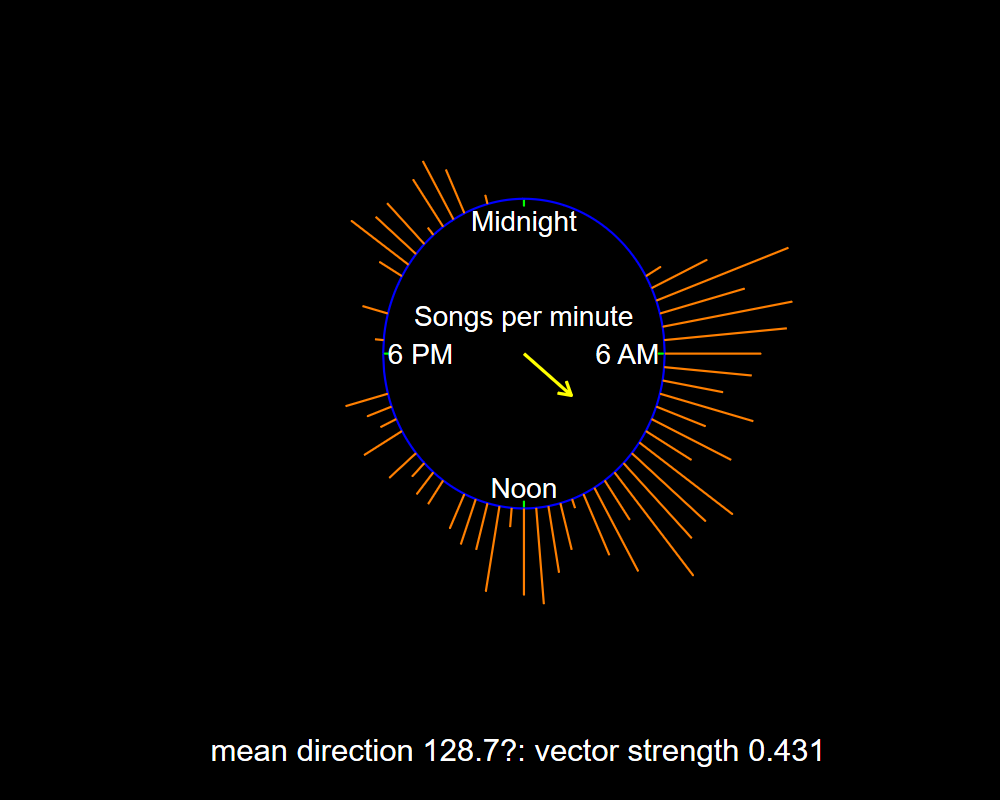

In [9]:
%%stata
frame change baseTIMEOFDAY
gen degrees = propday*(15)
circsummarize degrees if location=="H-P10-31-33" & species_code=="OVEN", detail
circrplot degrees if location=="H-P10-31-33" & species_code=="OVEN", clabel (0 "Midnight" 90 "6 AM" 180 "Noon" 270 "6 PM") text(0.25 0 "Songs per minute")

 The average direction of Ovenbird singing is 128.7 degrees, which is 8:27:45 AM.  The strength (aka resultant length) is a measure of how concentrated the data is (closer to one the more concentrated the result).  The Rayleigh and Kuiper statistics are *P*-values that estimate whether the data is uniformly distributed or not.  This data is definitely not uniform indicating Ovenbirds are more like to sing at certain times of the day than others.     

### Data Analysis - Regression

The basic circular statistics described above require the data to be grouped in some way for analysis (more below).  However, often times we want to include other variables besides time of day in our models (i.e. weather). To seperate the effects of time of day and another predictor variable we typically rely on some form of regression. While regression is often viewed as "linear" there are a multitude of methods one can use to fit a non-linear relationship between the response and predictor variable. Polynomial regression is a common approach whereby the predictor variable is raised to a power which then fits a non-linear function. For example,  including time of day and time of day squared fits a quadratic. In the Ovenbird example this would result in song rate peaking around 8 AM and dropping to low levels at all other times of the day (single peak).  Adding more polynomial terms increases the complexity of the non-linear relationship but reduces our ability to describe general patterns (i.e. overfits the data). Before using polynomial regression a key step is to determine the distribution of your data. In this case we assess if song counts are better fit by a Poisson or negative binomial distribution.         


Obtaining Parameter Estimates

  Observed Proportions

  +---------------+
  |  k      oprob |
  |---------------|
  |  0   .3194444 |
  |  1   .0555556 |
  |  2   .0555556 |
  |  3   .0694444 |
  |  4   .0277778 |
  |---------------|
  |  5   .0972222 |
  |  6   .0694444 |
  |  7   .0694444 |
  |  8   .0138889 |
  |  9   .0277778 |
  |---------------|
  | 10   .0694444 |
  +---------------+

  Negative Binomial Probabilities
  with mean = 4.541667 & overdispersion = 1.463982

     +------------------------------+
     |  k       nbprob        nbcum |
     |------------------------------|
  1. |  0   0.24913838   0.24913839 |
  2. |  1   0.14792987   0.39706826 |
  3. |  2   0.10821280   0.50528103 |
  4. |  3   0.08412792   0.58940899 |
  5. |  4   0.06733501   0.65674400 |
     |------------------------------|
  6. |  5   0.05482169   0.71156567 |
  7. |  6   0.04513724   0.75670290 |
  8. |  7   0.03745966   0.79416257 |
  9. |  8   0.03127228   0.82543486 |
 10. |  9   0.02622656 

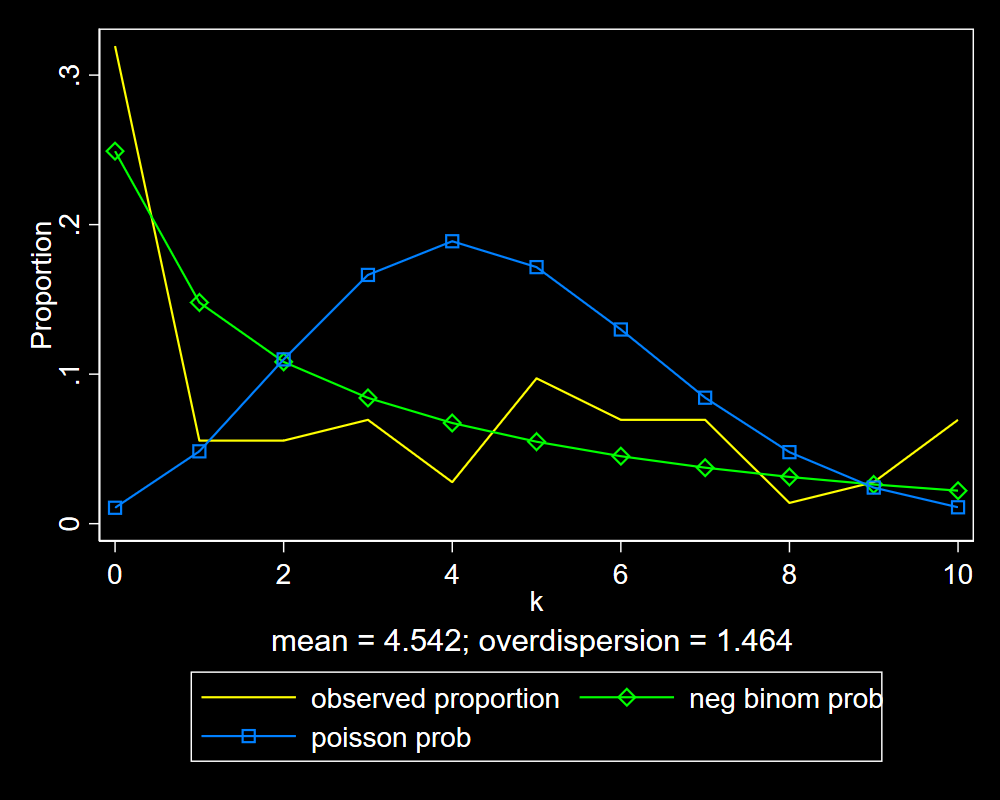

In [10]:
%%stata
frame change byminTIMEOFDAY
nbvargr songcnt if location=="H-P10-31-33" 

Based on this plot, the data are somewhat overdispersed suggesting a negative binomial distribution better describes the number of songs per minute given by Ovenbirds.  We will now compare the fit of various negative binomial regression models using various polynomial terms up to 5th order. We will use AIC to compare model fit of different polynomial complexity.

In [11]:
%%stata
quietly nbreg songcnt c.propday if location=="H-P10-31-33"
est store linear
quietly nbreg songcnt c.propday##c.propday if location=="H-P10-31-33"
est store power2
quietly predict FITpower2
quietly nbreg songcnt c.propday##c.propday##c.propday if location=="H-P10-31-33"
est store power3
quietly predict FITpower3
quietly nbreg songcnt c.propday##c.propday##c.propday##c.propday if location=="H-P10-31-33"
est store power4
quietly predict FITpower4
quietly nbreg songcnt c.propday##c.propday##c.propday##c.propday##c.propday if location=="H-P10-31-33"
est store power5
est stat *


Akaike's information criterion and Bayesian information criterion

-----------------------------------------------------------------------------
       Model |          N   ll(null)  ll(model)      df        AIC        BIC
-------------+---------------------------------------------------------------
      linear |         72  -186.9652  -186.1178       3   378.2356   385.0656
      power2 |         72  -186.9652  -179.4169       4   366.8339   375.9405
      power3 |         72  -186.9652  -164.6223       5   339.2447    350.628
      power4 |         72  -186.9652  -154.0129       6   320.0258   333.6858
      power5 |         72  -186.9652  -153.9793       7   321.9585   337.8952
-----------------------------------------------------------------------------
Note: BIC uses N = number of observations. See [R] BIC note.



Based on AIC the polynomial that best fits this data is a fourth order predictor.  The average (predicted) song count per minute as a function of time of day fit as a 4th order polynomial is shown below.

(results power4 are active now)

Adjusted predictions                                        Number of obs = 72
Model VCE: OIM

Expression: Predicted number of events, predict()

------------------------------------------------------------------------------
             |            Delta-method
             |     Margin   std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         _at |
          1  |   .0000413   .0000915     0.45   0.652     -.000138    .0002205
          2  |   .0025492   .0037359     0.68   0.495    -.0047731    .0098715
          3  |   .0576879   .0525608     1.10   0.272    -.0453295    .1607052
          4  |   .5589943   .2930675     1.91   0.056    -.0154076    1.133396
          5  |    2.67869   .7648656     3.50   0.000     1.179581    4.177799
          6  |   7.243667   1.349521     5.37   0.000     4.598654    9.888679
          7  |   12.46294   2.225619     5.60   0.000   

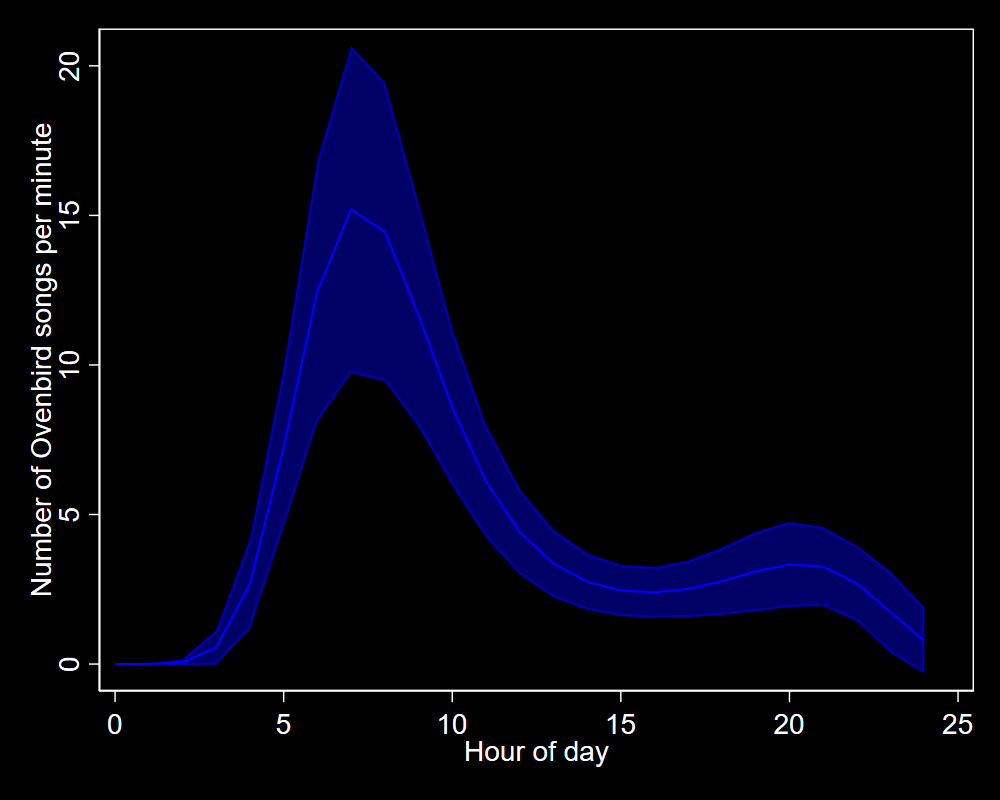

In [12]:
%%stata
est restore power4
margins, at(propday=(0(1)24)) noatlegend
marginsplot, recast(line) recastci(rarea) plot1opts(lcolor(blue)) ci1opts(acolor(blue%50)) xtitle(Hour of day) ytitle(Number of Ovenbird songs per minute) title("")                    

Relative to the circular plot above, the polynomial regression shows similar patterns with singing starting around 3 AM, rapidly increasing to a peak near 7AM followed by a slower decline till noon whereafter singing rates are stable but low.  A small second peak occurs around 8 PM which is consistent with the circular plot.  While describing the general pattern relatively well, there is one major flaw with the polynomial approach.  Remember, midnight is 0 and 11:59:59 PM is around 0.99999 of a day.  As these time periods are close together you would expect that transitioning from one to the other should result in a very similar songrate.  In the table above, the category 1 represents the predicted mean song count at midnight which is 0.000 songs per minute.  In the same table, 25 represents ~11:59:59 PM and the estimated song rate is 0.789 songs per minute.  This is not sensible, how could Ovenbird behavior change so dramatically in a second?  This occurs because the regression model does not know the relationship is circular and thus views 0 (midnight) as a very different time than 0.99999 (11:59:59) and represents a flaw in using this approach for prediction.

So what solutions exist?  There are several but one of the the easiest is to use predictor variables that are [sine/ cosine values](https://stats.stackexchange.com/questions/336613/regression-using-circular-variable-hour-from-023-as-predictor) instead of polynomial terms.  These predictor variables can be used in any time of regression (logistic, Poisson, normal). Again, AIC can be used to decide how complex the order of sine-cosine variables that provide the best fit.   

In [13]:
%%stata
frame change byminTIMEOFDAY
gen tstod = 2*c(pi)*(propday/24)
gen sinstod = sin(tstod)
gen cosstod = cos(tstod)
gen tstod2 = 2*c(pi)*(2*propday/24)
gen sin2stod = sin(tstod2)
gen cos2stod = cos(tstod2)
gen tstod3 = 3*c(pi)*(3*propday/24)
gen sin3stod = sin(tstod3)
gen cos3stod = cos(tstod3)
gen tstod4 = 4*c(pi)*(4*propday/24)
gen sin4stod = sin(tstod4)
gen cos4stod = cos(tstod4)
gen tstod5 = 5*c(pi)*(5*propday/24)
gen sin5stod = sin(tstod5)
gen cos5stod = cos(tstod5)

In [14]:
%%stata
quietly nbreg songcnt c.propday if location=="H-P10-31-33"
est store linear
quietly nbreg songcnt c.sinstod c.cosstod if location=="H-P10-31-33"
est store sincos
quietly predict FITsincos if location=="H-P10-31-33"
quietly nbreg songcnt c.sinstod c.cosstod c.sin2stod c.cos2stod if location=="H-P10-31-33"
est store sin2cos2
quietly predict FITsin2cos2 if location=="H-P10-31-33"
quietly nbreg songcnt c.sinstod c.cosstod c.sin2stod c.cos2stod c.sin3stod c.cos3stod if location=="H-P10-31-33"
est store sin3cos3
quietly predict FITsin3cos3 if location=="H-P10-31-33"
quietly nbreg songcnt c.sinstod c.cosstod c.sin2stod c.cos2stod c.sin3stod c.cos3stod c.sin4stod c.cos4stod if location=="H-P10-31-33"
est store sin4cos4
quietly nbreg songcnt  c.sinstod c.cosstod c.sin2stod c.cos2stod c.sin3stod c.cos3stod c.sin4stod c.cos4stod  c.sin5stod c.cos5stod if location=="H-P10-31-33" 
est store sin5cos5
est stat *


Akaike's information criterion and Bayesian information criterion

-----------------------------------------------------------------------------
       Model |          N   ll(null)  ll(model)      df        AIC        BIC
-------------+---------------------------------------------------------------
      linear |         72  -186.9652  -186.1178       3   378.2356   385.0656
      power2 |         72  -186.9652  -179.4169       4   366.8339   375.9405
      power3 |         72  -186.9652  -164.6223       5   339.2447    350.628
      power4 |         72  -186.9652  -154.0129       6   320.0258   333.6858
      power5 |         72  -186.9652  -153.9793       7   321.9585   337.8952
      sincos |         72  -186.9652  -177.6909       4   363.3817   372.4884
    sin2cos2 |         72  -186.9652  -169.3288       6   350.6577   364.3177
    sin3cos3 |         72  -186.9652  -162.1883       8   340.3766   358.5899
    sin4cos4 |         72  -186.9652  -161.7307      10   343.4615   366.2

The best fitting sine/ cosine variables include third order terms.  Based on AIC the 3rd order sine-cosine terms did not fit as well as the best fitting polynomial model.  However, as shown below the transition between 11:59 PM and midnight is far more logical (i.e. the lines connect as they cross from 11:59:59 PM to midnight).  Although the 3rd order sine-cosine function has a better fit than the 2nd order sine-cosine terms based on AIC, it seems like the 3rd order terms overfits some aspects of the data and might be less generalizable.  The 3rd order polynomial shows how bad the polynomial approach can be at fitting a logical transition between 11:59:59 PM and midnight.  In that example, singing rate at midnight is estimated to be 0 while at 11:59:59 PM it predicts an average song rate well over 5 songs per minute.  The sine-cosine functions don't suffer from this problem but do estimate that Ovenbirds sing between midnight and 4AM which the raw data shows did not happen which is a less severe issue for prediction but still is "not perfect".         

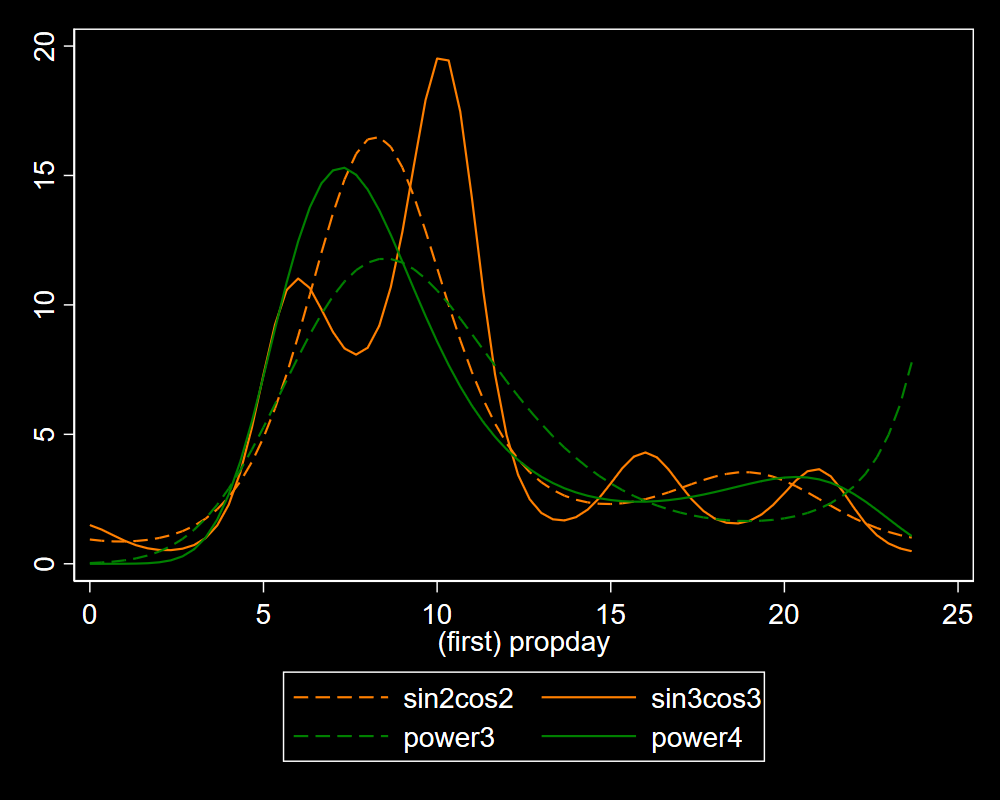

In [15]:
%%stata
label variable FITsin2cos2 "sin2cos2"
label variable FITsin3cos3 "sin3cos3"
label variable FITpower3 "power3"
label variable FITpower4 "power4"
twoway (line FITsin2cos2 propday, sort lcolor(orange) lpattern(dash)) (line FITsin3cos3 propday, sort lcolor(orange) lpattern(solid))  (line FITpower3 propday, sort lcolor(green) lpattern(dash)) (line FITpower4 propday, sort lcolor(green) lpattern(solid)) 

## Ovenbird singing at multiple locations

In the previous example, we assessed the behavior of Ovenbirds at a single location.  If there is the same sampling design at other locations you can pool together (sum) the singing observations to increase statistical power and to increase generality of the results.  However, whether or not Ovenbirds at two or more locations have the same singing behavior may be one of the fundamental questions.  Thus, before pooling data it can be useful to determine if the patterns in singing behavior are the same or very different. Let's repeat the analyses above recognizing that we have two different locations from which the singing behavior were observed.  So now we have 72 1-minute sampling periods from two locations (H-P10-31-33 & H-P15-33-18) for a total *n* = 144 replicates.

### Data Analysis - Chi-square Comparison of Two Groups

Our first question is does the pattern of singing differ between these two locations? The simplest way to test this is a chi-square test. This is not a goodness of fit test, rather is comparing whether the proportion of all of the songs observed per day differs in terms of which hour of the day they occur.  While a chi-square conceptually tests if proportions are different, we do NOT enter the proportions directly into the chi-square table, rather we compare the counts. The chi-square does NOT test whether the number of songs over the day or number of songs in each hour are different.

In [16]:
%%stata
frame change baseTIMEOFDAY
gen use2loc = 1 if location=="H-P10-31-33"
replace use2locs = 1 if location=="H-P15-33-18"
tabulate shod location if species_code=="OVEN" & use2loc==1, chi2 column cchi2


(966 missing values generated)

variable use2locs not found
r(111);

+-------------------+
| Key               |
|-------------------|
|     frequency     |
| chi2 contribution |
| column percentage |
+-------------------+

           |  location
      shod | H-P10-3.. |     Total
-----------+-----------+----------
         4 |        25 |        25 
           |       0.0 |       0.0 
           |      7.65 |      7.65 
-----------+-----------+----------
         5 |        39 |        39 
           |       0.0 |       0.0 
           |     11.93 |     11.93 
-----------+-----------+----------
         6 |        28 |        28 
           |       0.0 |       0.0 
           |      8.56 |      8.56 
-----------+-----------+----------
         7 |        27 |        27 
           |       0.0 |       0.0 
           |      8.26 |      8.26 
-----------+-----------+----------
         8 |        30 |        30 
           |       0.0 |       0.0 
           |      9.17 |      9.17 
--

So the tabulate command shows several things about this data.  First, far more Ovenbird songs were counted in H-P10-31-33 vs. H-P15-33-18. There is no explicit statistical test for this but see Total in table above which shows 327 vs 139 songs.  This table also shows the frequences of songs observed in each location in the first row, how much of the difference between locations is explained by the difference in percentages of songs in each hour, and the percentage of all songs from each location that occurred in a particular hour. 

The Pearson chi-square test is highly significant indicating that there is a difference in the proportion of songs occurring at different hours of the day.  Now there are two key things you have to consider here.  Look at the top of the table.  Hours 0, 1, 2, and 3 do not exist in this table.  This is because there are no songs observed at either location at these hours of the day. Thus, those hours of the day are identical. While you could force these cells into the chi-square, it is a problematic statistical solution but an important biological reality.  You can also looked at the third row in each hour at each location where the percentage of all songs at that location to determine which hours of the day are the most different / similar at each location.  The second row tells you how much that particular hour of the day influences whether the chi-square concludes there is a difference.  For exmaple, at hour 22, the percentage of the total songs at each location is virtually identical (3.67% vs 3.60%) and contributes very little to the overall chi-square statistic.  In contrast, hour 6 has the greatest difference in percentage of songs occuring between the two locations and thus the greatest effect on the overall chi-square statistic which results in us concluding that diel patterns of singing differ between the two locations.

Now why are things different between these two locations?  There are many possible biological explanations.  Some hypotheses that could be tested but not with a chi-square are:

1) The weather was different with higher wind in the early morning at H-P15-33-18 that dropped off later in the day and birds don't sing or are harder to hear when it is windy (this did occur but is it causal?)

2) More individual Ovenbirds at H-P10-31-33 resulting in different behavioral processes influencing how we estimate the singing rate of the species. Ovenbirds often counter-sing with each other.  
(I don't think this is likely because I estimated a maximum of 4 individuals at each location).

3) Different time of year (H-P10-31-33 was surveyed on May 29, 2021 while H-P15-33-18 was surveyed on July 2, 2021. Later in the season Ovenbirds sing less and maybe change their behavior in relation to hour of day OR sunrise time has changed and the singing behavior is identical in terms in time since sunrise but not hour of day.

Now circular statistics that use time of day don't explictly less us test any of these hypotheses BUT do help with the all zero problem that occurs at night. 

### Data Analysis - Circular Comparisons of Two Groups

The benefit of using circular statistics to compare if two circular distributions are different is that zero counts are properly accounted for. There are several tests one can use in this regard but in Stata for this and data set I used the Mardia-Watson-Wheeler test for homogeneity on two or more samples of circular data. A significant result indicates that the circular distributions are different in overall concentration so you can have a similar mean direction but a different strength or vice versa.   

In [17]:
%%stata
frame change baseTIMEOFDAY
circwwmardia degrees if species_code=="OVEN" & use2loc==1, by(location)


     Variable |   Obs       W_r     df     P-value
 -------------+-----------------------------------
      degrees |   327         .      0           .



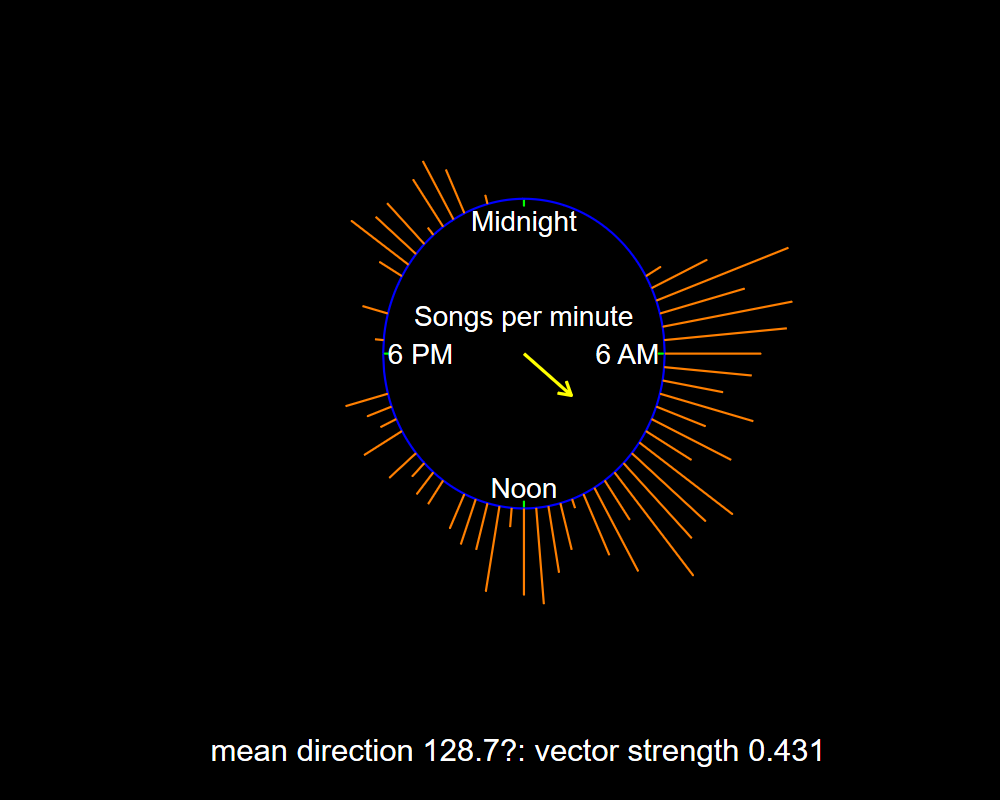

In [18]:
%%stata
circrplot degrees if location== "H-P10-31-33" & species_code=="OVEN", clabel (0 "Midnight" 90 "6 AM" 180 "Noon" 270 "6 PM") text(0.25 0 "Songs per minute")

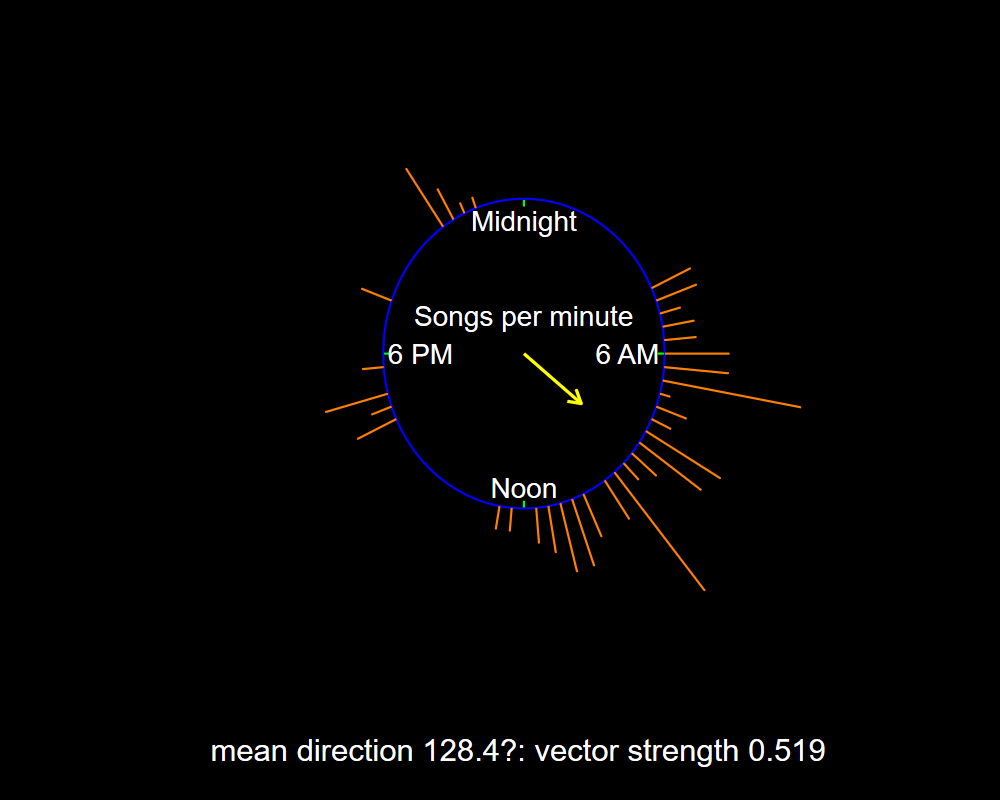

In [19]:
%%stata 
circrplot degrees if location=="H-P15-33-18" & species_code=="OVEN", clabel (0 "Midnight" 90 "6 AM" 180 "Noon" 270 "6 PM") text(0.25 0 "Songs per minute")

Based on a rejection criteria of *P* <= 0.05, the two locations do not differ in terms of the temporal pattern of singing of Ovenbirds based on the Mardia-Watson-Wheeler test with *P* = 0.053. The mean direction is  similar between the two locations but the vector strength is somewhat different with more concentrated singing in the morning at H-P15-33-18 (July 2, 2021) than H-P10-31-33 (May 29, 2021) where singing occurs across more of the diurnal period.  

Now you are probably wondering, can I use this test for more than 2 locations?  The answer is yes and you can think of it like an ANOVA.  However, if you want to figure out which group is different from another you would have to do pairwise comparisons that correct for the number of comparisons made using something like a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction).

### FUTURE CONCEPTS

There are many other ways to fit time of day data and as time permits I will continue to add examples in both Stata and R.

Papers that I am using to develop new concepts:

https://www.frontiersin.org/articles/10.3389/fpsyg.2018.02040/full

https://peerj.com/articles/6876/

General themes/ data I plan to add:

Lags and time-series analysis to demonstrate temporal autocorrelation

Pooling data, vs. summary stats for daily patterns vs. random effects for 1 minutes nested in location when dealing with multiple locations

Shift from midnight to sunset as the circular data - Night and day



In [20]:
%%stata
circsummarize degrees if species_code=="OVEN", by(location)


        Group |   Obs    Mean  Strength  Range
 -------------+-------------------------------
  H-P10-31-33 |   327   128.7     0.431  285.0
  H-P15-22-24 |   127    93.6     0.329  275.0
  H-P15-33-18 |   139   128.4     0.519  275.0
    H-P15-7-8 |    97   150.0     0.461  310.0
  S-P10-19-68 |   227   133.2     0.585  275.0
   S-P10-22-3 |   212   118.7     0.509  300.0

